In [1]:
import atmospy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os

# disable warnings for demo purposes
warnings.filterwarnings("ignore")

atmospy.set_theme()

# this tutorial was completed using version:
atmospy.__version__

'0.1.2'

In [2]:
# Initialize an empty DataFrame
df_lcs = pd.DataFrame()

# Define the start and end months and years
start_month = 11
start_year = 2023
end_month = 2
end_year = 2024

# Function to generate month-year strings
def generate_month_year_strings(start_month, start_year, end_month, end_year):
    month_year_list = []
    year = start_year
    month = start_month
    while year < end_year or (year == end_year and month <= end_month):
        month_year_list.append(f"{year}_{str(month).zfill(2)}")
        month += 1
        if month > 12:
            month = 1
            year += 1
    return month_year_list

# Generate the list of month-year strings
month_year_strings = generate_month_year_strings(start_month, start_year, end_month, end_year)

# Loop through each month-year string and load the CSV files
for month_year_string in month_year_strings:
    year, month = month_year_string.split('_')
    filename_tail = f"@devnode_{year}-{month}.csv"
    directory = os.path.join("lcs_data", month_year_string)

    df_co = pd.read_csv(os.path.join(directory, f"raw_CO-B4{filename_tail}"), sep=',')
    df_pm_opcn3 = pd.read_csv(os.path.join(directory, f"raw_PM-OPCN3{filename_tail}"), sep=',')
    df_pm_sps30 = pd.read_csv(os.path.join(directory, f"raw_PM-SPS30{filename_tail}"), sep=',')
    df_trh = pd.read_csv(os.path.join(directory, f"raw_T_RH_P_BME280{filename_tail}"), sep=',')
 
    # Combining all datasets using the "Čas" column
    df_temp = pd.merge(df_co, df_trh, on="Čas")
    df_temp = pd.merge(df_temp, df_pm_opcn3, on="Čas")
    df_temp = pd.merge(df_temp, df_pm_sps30, on="Čas")
    
    # Calculating actual values for the WE (working electrode) and AE (auxiliary electrode) values
    df_temp["CO"] = df_temp["WE_CO"] - df_temp["AE_CO"]
      
    # Dropping the extra columns (including the pressure - that makes a negligible difference)
    df_temp = df_temp.drop(["WE_CO", "AE_CO", "PM_4"], axis=1)
    
    # Renaming the "Čas" column
    df_temp = df_temp.rename(columns={'Čas': 'Time'})
    
    # Converting the time to a datetime
    df_temp['Time'] = pd.to_datetime(df_temp['Time'])
    
    # 1h shift of the CSV data (CSV seems to be UTC+1, reference data UTC)
    df_temp['Time'] += pd.Timedelta(hours=1)
    
    # Set 'Time' column as the DataFrame index
    df_temp.set_index('Time', inplace=True)
    
    # Resample to 1-hour intervals and calculate the mean for each group
    df_temp_1h = df_temp.resample('1h').mean()
    
    # Assign the calculated hourly means back to the original DataFrame
    df_temp = df_temp_1h.reset_index()
    
    # Append the data to the main DataFrame
    df_lcs = pd.concat([df_lcs, df_temp], ignore_index=True)

# Renaming the "Time" column to "GMT"
df_lcs = df_lcs.rename(columns={'Time': 'GMT'})

# Set 'GMT' column as the DataFrame index
df_lcs.set_index('GMT', inplace=True)

# Print the data types of the final DataFrame
print(df_lcs.dtypes)

T          float64
RH         float64
p          float64
PM_1_x     float64
PM_2.5     float64
PM_10_x    float64
PM_1_y     float64
PM_2       float64
PM_10_y    float64
CO         float64
dtype: object


In [3]:
# The edited dataset has the "Celkem" values at the end of the data removed
#df_ref = pd.read_excel(month_year_string + "/MS_MarianskeHory_60min_" + month_year_string + "_edited.xlsx")
df_ref = pd.DataFrame()

df_ref = pd.read_csv('gmt_data/Nov-Feb_GMT_MarHory.csv', sep=';')
#df_ref = pd.read_csv('gmt_data/Apr-Jul_GMT_MarHory.csv', sep=';')

#df_ref = df_ref.rename(columns={
#        'Unnamed: 0': 'Time',
#        'Celaskon; 1663_MarHory; WSPE [m/s]': 'WSPE [m/s]',
#        'Celaskon; 1663_MarHory; WDIR [deg]': 'WDIR [deg]',
#        'Celaskon; 1663_MarHory; HUMI [%]': 'HUMI [%]',
#        'Celaskon; 1663_MarHory; PRES [hPa]': 'PRES [hPa]',
#        'Celaskon; 1663_MarHory; TEMP [°C]': 'TEMP [°C]',
#        'Celaskon; 1663_MarHory; PM10 [ug/m3]': 'PM10 [µg/m3]',
#        'Celaskon; 1663_MarHory; O3 [ug/m3]': 'O3 [µg/m3]',
#        'Celaskon; 1663_MarHory; SO2 [ug/m3]': 'SO2 [µg/m3]',
#        'Celaskon; 1663_MarHory; NO [ug/m3]': 'NO [µg/m3]',
#        'Celaskon; 1663_MarHory; NO2 [ug/m3]': 'NO2 [µg/m3]',
#        'Celaskon; 1663_MarHory; CO [ug/m3]': 'CO [µg/m3]'
#})

#Apply the function to the entire column
df_ref['GMT'] = pd.to_datetime(df_ref['GMT'])

#Synchronizing the datatypes of "Time" in the datasets
df_ref['GMT'] = df_ref['GMT'].dt.tz_localize('UTC')

# Dropping the extra columns (including the pressure - that makes a negligible difference)
df_ref = df_ref.drop(["TIME"], axis=1)

# Pokud potřebujete změnit pouze určité sloupce, můžete specifikovat sloupce takto:

df_ref[['WDIR [deg]', 
        'HUMI [%]', 
        'PRES [hPa]', 
        'TEMP [°C]', 
        'PM10 [ug/m3]', 
        'PM25 [ug/m3]', 
        'PM01 [ug/m3]', 
        'O3 [ug/m3]', 
        'SO2 [ug/m3]', 
        'NO [ug/m3]', 
        'NO2 [ug/m3]', 
        'CO [ug/m3]']] = df_ref[['WDIR [deg]', 
                                 'HUMI [%]', 
                                 'PRES [hPa]', 
                                 'TEMP [°C]', 
                                 'PM10 [ug/m3]', 
                                 'PM25 [ug/m3]', 
                                 'PM01 [ug/m3]', 
                                 'O3 [ug/m3]', 
                                 'SO2 [ug/m3]', 
                                 'NO [ug/m3]', 
                                 'NO2 [ug/m3]', 
                                 'CO [ug/m3]']].astype('float64')

#df_ref.head()
#print(df_ref.describe())
print(df_ref.dtypes)

GMT             datetime64[ns, UTC]
WSPE [m/s]                  float64
WDIR [deg]                  float64
HUMI [%]                    float64
PRES [hPa]                  float64
TEMP [°C]                   float64
PM10 [ug/m3]                float64
PM25 [ug/m3]                float64
PM01 [ug/m3]                float64
O3 [ug/m3]                  float64
SO2 [ug/m3]                 float64
NO [ug/m3]                  float64
NO2 [ug/m3]                 float64
CO [ug/m3]                  float64
dtype: object


In [4]:
df_cams = pd.DataFrame()

df_cams = pd.read_csv('gmt_data/Nov-Feb_gmt_CAMS-EUR.csv', sep=';')

df_cams['GMT'] = pd.to_datetime(df_ref['GMT'])

#Synchronizing the datatypes of "Time" in the datasets
df_cams['GMT'] = df_cams['GMT'].dt.tz_convert('UTC')

# Dropping the extra columns (including the pressure - that makes a negligible difference)
df_cams = df_cams.drop(["gmt"], axis=1)

#df_ref.head()
#print(df_ref.describe())
print(df_cams.dtypes)

pm10 (μg/m³)                            float64
pm2_5 (μg/m³)                           float64
carbon_monoxide (μg/m³)                 float64
nitrogen_dioxide (μg/m³)                float64
sulphur_dioxide (μg/m³)                 float64
ozone (μg/m³)                           float64
dust (μg/m³)                            float64
uv_index ()                             float64
ammonia (μg/m³)                         float64
GMT                         datetime64[ns, UTC]
dtype: object


In [5]:
# Merge the two DataFrames on the 'Time' column
df = pd.merge(df_lcs, df_ref, on='GMT')
df = pd.merge(df, df_cams, on='GMT')
# Sorting the values by the "Time" attribute
df.sort_values(by="GMT")
# Check the correlation between 'CO' and 'CO [µg/m3]'
#correlation = df_merged['CO'].diff().corr(df_merged['CO [ug/m3]'].diff())
#print(f'Correlation between CO and CO [µg/m3]: {correlation}')

df.head()
#print(df.describe())
#print(df.dtypes)

,GMT,T,RH,p,PM_1_x,PM_2.5,PM_10_x,PM_1_y,PM_2,PM_10_y,...,CO [ug/m3],pm10 (μg/m³),pm2_5 (μg/m³),carbon_monoxide (μg/m³),nitrogen_dioxide (μg/m³),sulphur_dioxide (μg/m³),ozone (μg/m³),dust (μg/m³),uv_index (),ammonia (μg/m³)
0,2023-11-01 01:00:00+00:00,9.420767,86.635767,983.170000,2.253767,3.097233,6.127400,10.019933,10.595767,10.596100,...,100.0,10.0,NaN,200.0,6.5,1.9,41.0,0.0,NaN,1.4
1,2023-11-01 02:00:00+00:00,9.272361,85.462083,984.000000,2.059694,2.892361,5.809806,9.804333,10.377417,10.389111,...,100.0,10.4,NaN,200.0,6.4,1.7,41.0,0.0,NaN,1.3
2,2023-11-01 03:00:00+00:00,8.937389,85.388028,984.000000,1.958361,2.902167,6.335556,9.097944,9.625056,9.630417,...,100.0,11.0,NaN,200.0,7.1,1.7,40.0,0.0,NaN,1.1
3,2023-11-01 04:00:00+00:00,8.531500,85.452583,984.000000,1.864639,2.887278,6.491056,8.200333,8.673222,8.675056,...,100.0,11.4,NaN,201.0,7.8,1.6,39.0,0.0,NaN,1.1
4,2023-11-01 05:00:00+00:00,8.240945,85.452805,984.236111,1.886333,3.079111,6.654306,8.249611,8.741583,8.763639,...,100.0,12.4,NaN,211.0,9.1,2.0,36.0,0.0,NaN,1.2


In [6]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Assuming df is your DataFrame
df_drop = pd.DataFrame()  # Replace this with your actual DataFrame

df_drop = df.drop(['PM_1_x', 'PM_2.5', 'PM_10_x', 'PM_1_y', 'PM_2',
       'PM_10_y','WSPE [m/s]', 'WDIR [deg]', 'HUMI [%]', 'PRES [hPa]',
       'TEMP [°C]', 'PM10 [ug/m3]', 'PM25 [ug/m3]', 'PM01 [ug/m3]',
       'O3 [ug/m3]', 'SO2 [ug/m3]', 'NO [ug/m3]', 'NO2 [ug/m3]',
       'pm10 (μg/m³)', 'pm2_5 (μg/m³)', 'carbon_monoxide (μg/m³)',
       'nitrogen_dioxide (μg/m³)', 'sulphur_dioxide (μg/m³)', 'ozone (μg/m³)',
       'dust (μg/m³)', 'uv_index ()', 'ammonia (μg/m³)'], axis=1)

df_drop.head()
df=df_drop

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Drop rows with missing values
df = df.dropna()

print("Columns in DataFrame:", df.columns)

# Check the number of rows remaining
print(f"Number of rows after dropping NaNs: {len(df)}")

if len(df) == 0:
    raise ValueError("No data available after dropping rows with NaN values.")

# Define your features and target variable
features = ['CO', 'T']  # replace with your actual feature columns
target = 'CO [ug/m3]'

# Define the split date
split_date = '2024-01-01'

# Split the data
train = df[df['GMT'] < split_date]
test = df[df['GMT'] >= split_date]

# Split the data into X (features) and y (target)
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calculate mean squared error
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')


Columns in DataFrame: Index(['GMT', 'T', 'RH', 'p', 'CO', 'CO [ug/m3]'], dtype='object')
Number of rows after dropping NaNs: 2776
Train MSE: 1375.96850326589
Test MSE: 7099.959700186871


In [13]:
train_r2 = model.score(X_train, y_train)
test_r2 = model.score(X_test, y_test)

print(f'Train R^2: {train_r2}')
print(f'Test R^2: {test_r2}')

Train R^2: 0.9725735905509492
Test R^2: 0.8502122672670228


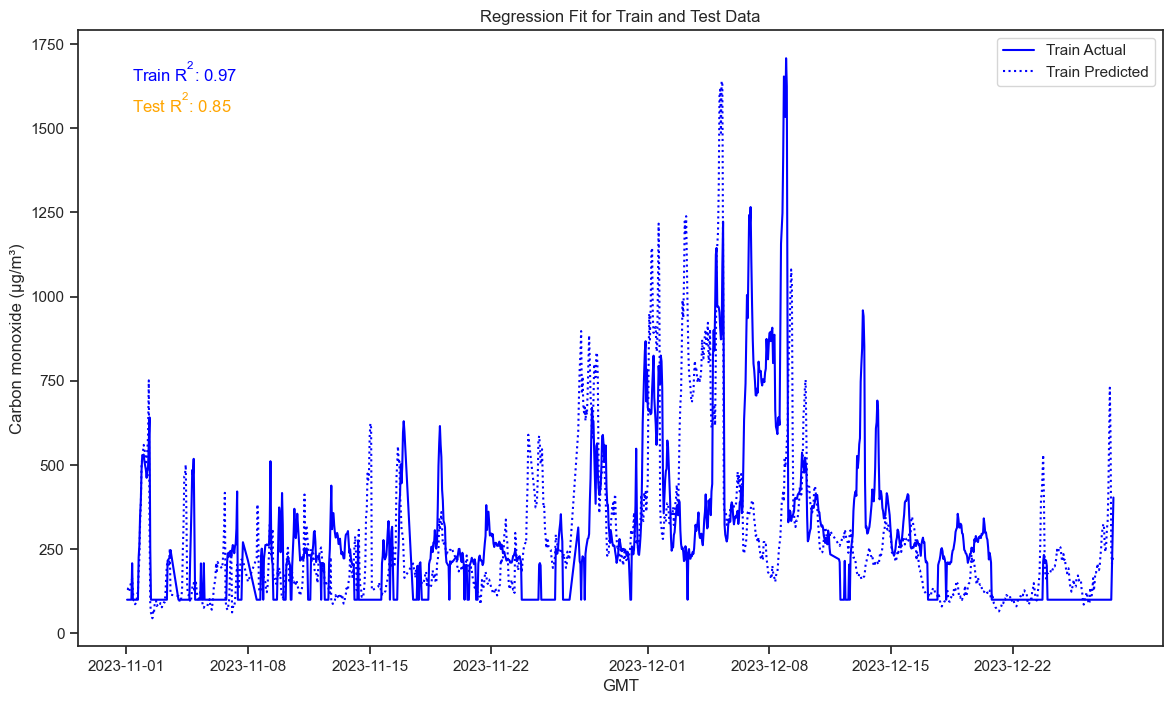

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

train = pd.DataFrame()
test = pd.DataFrame()

# Combine actual and predicted values for plotting
train['Predicted'] = y_pred_train
test['Predicted'] = y_pred_test

train['Set'] = 'Train'
test['Set'] = 'Test'

train['GMT'] = df["GMT"]
test['GMT'] = df["GMT"]

combined = pd.concat([train, test])

plt.figure(figsize=(14, 8))

# Plot actual values for train and test sets
sns.lineplot(data=train, x='GMT', y=df[target], label='Train Actual', color='blue')
#sns.lineplot(data=test, x='GMT', y=df[target], label='Test Actual', color='orange')

# Plot predicted values for train and test sets
sns.lineplot(data=train, x='GMT', y='Predicted', label='Train Predicted', color='blue', linestyle=':')
#sns.lineplot(data=test, x='GMT', y='Predicted', label='Test Predicted', color='orange', linestyle=':')

# Add R^2 values text
plt.text(0.05, 0.95, f'Train $R^2$: {train_r2:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', color='blue')
plt.text(0.05, 0.90, f'Test $R^2$: {test_r2:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', color='orange')

plt.xlabel('GMT')
plt.ylabel('Carbon monoxide (μg/m³)')
plt.title('Regression Fit for Train and Test Data')
plt.legend()
plt.show()